# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
#Import functions associated with Black-Scholes Equations
from functions_black_scholes import *

In [2]:
def simulate_path_with_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% chance the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths and the sigma choices
    '''
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma_choices = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma_choices**2)*dt + sigma_choices*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    #paths
    paths = S0*np.exp(log_returns)
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    return paths, sigma_choices

## Impact of Non-Constant Volatility on Delta Hedging Profits

This mini project investigates the profit distribution of delta hedging sold call options under non-constant volatility by simulating stock paths using two different models: a custom sigma model and the Heston model. The goal is to analyze how varying volatility impacts hedging outcomes.

The next section simulates the profit and loss distribution of a trader employing delta hedging to manage risk from selling European call options, but with a key difference: the stock's volatility is assumed to change randomly between discrete values, deviating from the standard Black-Scholes assumption of constant volatility. Using Monte Carlo simulations, this study will generate stock paths with varying volatility (as we've done extensively in class), calculate deltas using a control variate technique, and analyze the resulting profit distribution for a delta-hedged short call strategy. Furthermore, it will compare the Black-Scholes price and option premium calculated using average volatility values to the simulated outcomes.

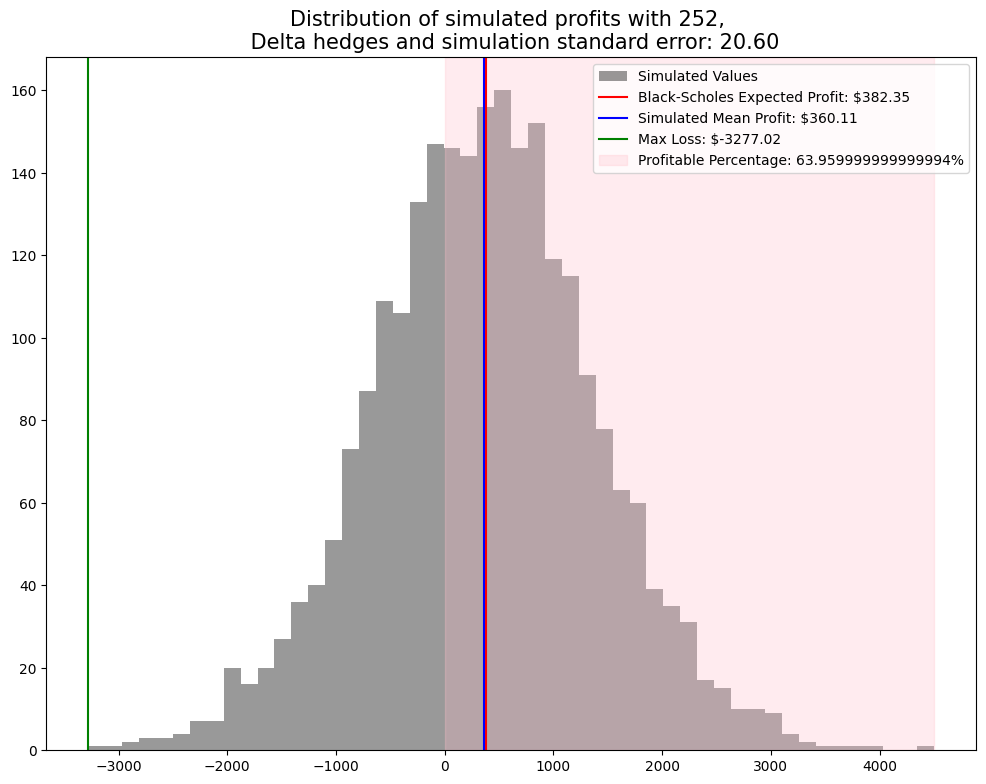

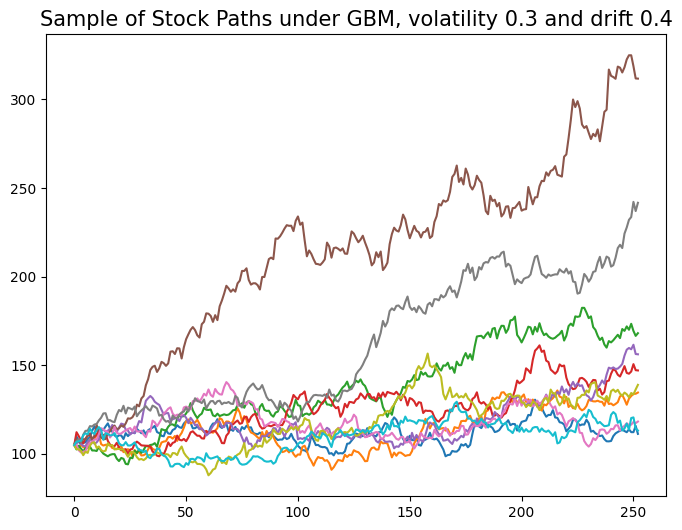

In [3]:
#Simulate and plot histograms of a 
#seller of 1000 call option contracts that receives a premium above the Black-Scholes Price

S0 = 105
K = 100
sigma = .3
t = 1
r = 0.035
mu = .4 #Drift of stock movement
n_sims = 2500
n_hedges = 252


premium = bs_call(S0,K,sigma + .01,t,r) #Increased volatility results in higher price in Black-Scholes model
num_options = 1000

bs_price = bs_call(S0,K,sigma,t,r)

sold_calls_hedged = bs_MC_call(S0, K, sigma, t, r, mu, n_sims, n_hedges)

profits_hedged = num_options*(premium - sold_calls_hedged)



plt.figure(figsize = (12,9))

plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')

plt.axvline(num_options*(premium-bs_price), label = f'Black-Scholes Expected Profit: ${num_options*(premium-bs_price):.2f}', color = 'red')

plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')

plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')

plt.axvspan(0,np.max(profits_hedged), color='pink', alpha=0.3,\
label = f'Profitable Percentage: {np.mean(profits_hedged>=0)*100}%')

plt.legend()

plt.title(f'Distribution of simulated profits with {n_hedges}, \n Delta hedges and simulation standard error: {np.std(profits_hedged)/np.sqrt(n_sims):.2f}',size = 15)

plt.show()



### Plot sample stock paths with brownian motion assumptions
noise = np.random.normal(0,1,(10,n_hedges))

dt = t/n_hedges

increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise

log_returns = np.cumsum(increments, axis = 1)

paths = S0*np.exp(log_returns)

paths = np.insert(paths, 0, S0, axis = 1)

plt.figure(figsize = (8,6))

for path in paths:
    plt.plot(path)
    
plt.title(f'Sample of Stock Paths under GBM, volatility {sigma} and drift {mu}', size = 15)

plt.show()

In [4]:
def MC_call_custom_sigma(S0, K, t, r, mu, n_paths, n_steps, delta_sims=250):
    paths, sigma_path = simulate_path_with_custom_sigma(S0, t, r, mu, n_paths, n_steps)
    dt = t / n_steps
    call_payoffs = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    delta_start = np.array([bs_MC_call_delta(S0, K, sigma_path[i, 0], t, r, delta_sims) for i in range(n_paths)])
    first_stock_profits = (paths[:, 1] - S0 * np.exp(dt * r)) * delta_start * np.exp(-dt * r)

    stock_profits = [first_stock_profits]

    for i in range(1, n_steps):
        S_start = paths[:, i]
        S_end = paths[:, i + 1]
        tte = t - i * dt
        sigmas = sigma_path[:, i]
        deltas = bs_MC_call_delta_array(S_start, K, sigmas, tte, r, delta_sims)
        profit = (S_end - S_start * np.exp(r * dt)) * deltas * np.exp(-i * dt * r)
        stock_profits.append(profit)

    total_stock_profit = np.sum(stock_profits, axis=0)
    return call_payoffs - total_stock_profit

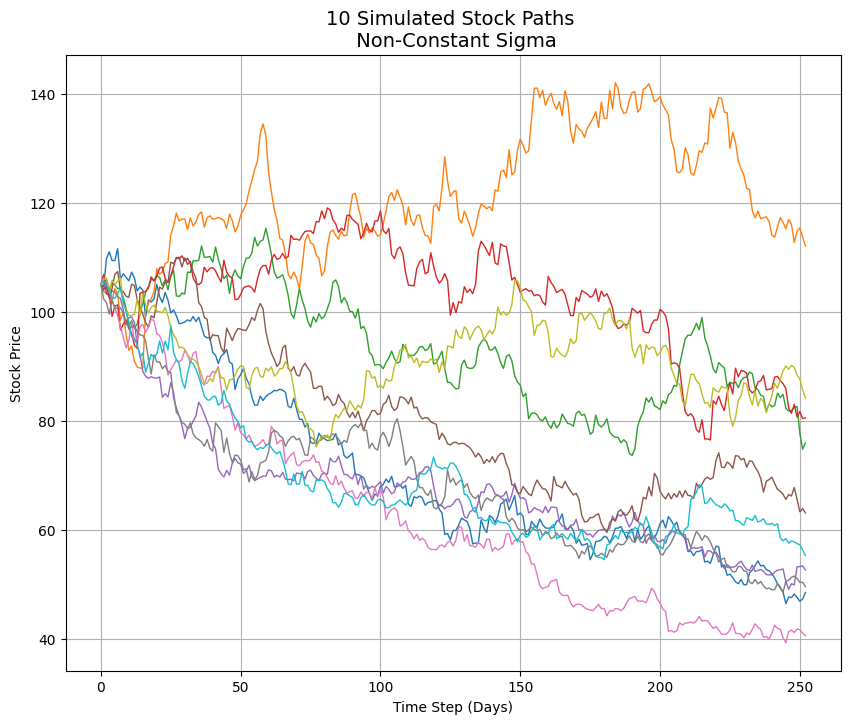

In [5]:
# Simulate a small number of stock paths using random sigma per step
S0 = 105
t = 1
r = 0.035
mu = -0.4
n_paths_sample = 10
n_steps = 252

# Reuse the same function from earlier
paths_sample, sigma_sample = simulate_path_with_custom_sigma(S0, t, r, mu, n_paths_sample, n_steps)

# Plot the sample paths
plt.figure(figsize=(10, 8))
for path in paths_sample:
    plt.plot(path, lw=1)

plt.title(f"{n_paths_sample} Simulated Stock Paths \n Non-Constant Sigma", fontsize=14)
plt.xlabel("Time Step (Days)")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()


Comparing profit distributions with non-constant custom volatilities to those with constant volatility reveals significant differences. The standard error substantially increased due to the variability in volatility, while the Black-Scholes expected profit remained similar, likely because the Black-Scholes price used a constant volatility derived from the average of these varying volatilities. However, the simulated mean profit decreased considerably, even becoming negative with negative drift, and the maximum potential loss increased markedly. Consequently, the percentage of profitable outcomes also dropped significantly, highlighting the substantial impact of non-constant volatility on hedging performance.

Next, we vary sigma's and update our function to see how this change affects the distribution 

In [6]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps, sigma_levels, sigma_probs):
    dt = t / n_steps
    noise = np.random.normal(0, 1, size=(n_paths, n_steps))
    sigma_path = np.random.choice(sigma_levels, p=sigma_probs, size=(n_paths, n_steps))
    increments = (mu + r - 0.5 * sigma_path**2) * dt + sigma_path * np.sqrt(dt) * noise
    log_returns = np.cumsum(increments, axis=1)
    paths = S0 * np.exp(log_returns)
    paths = np.insert(paths, 0, S0, axis=1)
    sigma_path = np.insert(sigma_path, 0, sigma_path[:, 0], axis=1)
    return paths, sigma_path


In [7]:
def MC_call_custom_sigma(S0, K, t, r, mu, n_paths, n_steps, delta_sims, sigma_levels, sigma_probs):
    paths, sigma_path = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps, sigma_levels, sigma_probs)
    dt = t / n_steps
    call_payoffs = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    delta_start = np.array([
        bs_MC_call_delta(S0, K, sigma_path[i, 0], t, r, delta_sims) for i in range(n_paths)
    ])
    first_profits = (paths[:, 1] - S0 * np.exp(dt * r)) * delta_start * np.exp(-dt * r)

    stock_profits = [first_profits]

    for i in range(1, n_steps):
        S_start = paths[:, i]
        S_end = paths[:, i + 1]
        tte = t - i * dt
        sigmas = sigma_path[:, i]
        deltas = bs_MC_call_delta_array(S_start, K, sigmas, tte, r, delta_sims)
        profit = (S_end - S_start * np.exp(r * dt)) * deltas * np.exp(-i * dt * r)
        stock_profits.append(profit)

    total_stock_profit = np.sum(stock_profits, axis=0)
    return call_payoffs - total_stock_profit

## Profit and Loss Distribution from Delta-Hedged Call Option Under Heston Model

### Heston Path Simulation




In [8]:
# Borrowed this sim and call method from lecture

def heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu=0, n_sims=1, return_vol=False):
    """
    Simulation of stock path movements under the Heston stochastic volatility model.
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    - vols (ndarray, optional): Simulated variance paths if return_vol is True
    """
    dt = t / n_steps
    N1 = np.random.normal(0, 1, size=(n_sims, n_steps))
    N2 = np.random.normal(0, 1, size=(n_sims, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths = np.zeros((n_sims, n_steps + 1))
    vols = np.zeros((n_sims, n_steps + 1))
    paths[:, 0] = S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
                                xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
    
    return (paths, vols) if return_vol else paths

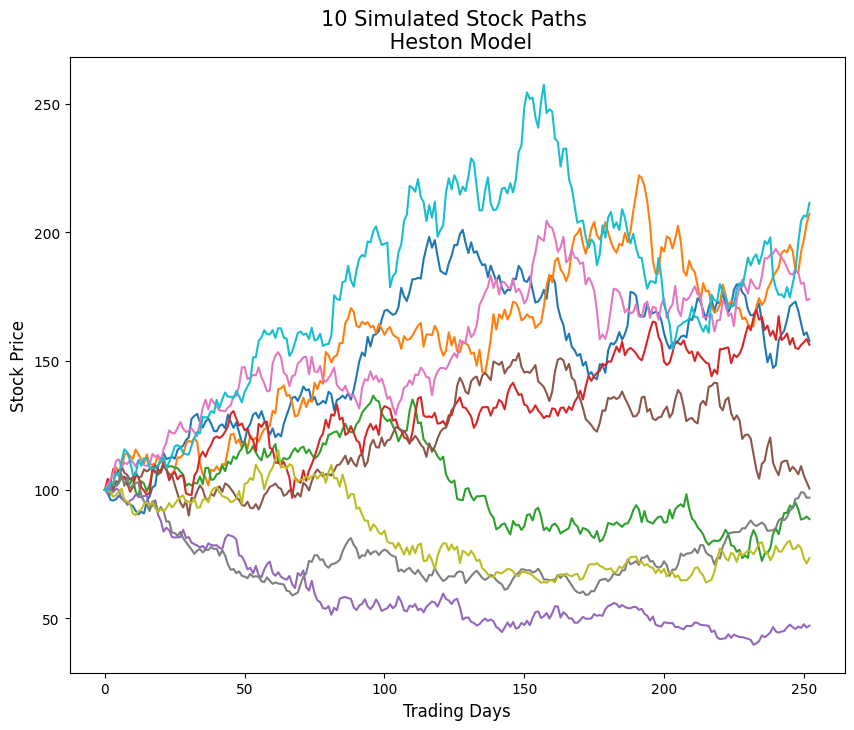

In [9]:
### Simulated stock paths under Heston model
kappa = 4
theta = .45**2
xi = .5
v0 = 0.4**2
rho = -0.05
S0 = 100
t = 1
n_steps = 252
r = 0.04
n_sims = 10
dt = t / n_steps
mu = .2


paths = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu, n_sims)


plt.figure(figsize = (10,8))

for path in paths:
    plt.plot(path)
    
plt.title(f'{n_sims} Simulated Stock Paths \n Heston Model', size = 15)
plt.xlabel('Trading Days', size = 12)
plt.ylabel('Stock Price', size = 12)

plt.show()

In [10]:
def heston_call_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=2500, mu=0):
    """
    Monte-Carlo Simulation of Call Option under Heston model with Black-Scholes Delta control variates
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - call_payouts (ndarray): Simulated payouts of a call-option
    """
    
    
    paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho,  mu, n_sims, return_vol=True)
    
    dt = t / n_steps

    # Compute BS deltas from previous steps volatility across all steps (n_steps, n_sims)
    # This is only an approximation of Delta of call option under Heston model.
    # The black-scholes deltas and Heston deltas are correlated enough so that black-scholes deltas
    # still work as a control variate in Monte-Carlo Simulation of Heston model option pricing
    
    deltas = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T  
    
    # Stock P&L from delta hedge
    stock_profits_steps = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * deltas * np.exp(-r * np.arange(1, n_steps + 1) * dt)
    stock_profits = np.sum(stock_profits_steps, axis=1)

    # Call payouts
    call_payouts = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    # Adjusted estimator
    call_payouts_hedged = call_payouts - stock_profits

    return call_payouts_hedged


In [11]:
# Analysis borrowed from AKM Sonnet

# Parameters
S0 = 105
K = 100
v0 = 0.09             # Initial variance (e.g., 0.3^2)
r = 0.035
t = 1
mu = 0.4              # Drift
n_steps = 252
n_sims = 2500
num_options = 1000

# Heston model parameters
kappa = 3.0           # Mean reversion speed
theta = 0.09          # Long-run variance
xi = 0.4              # Volatility of volatility
rho = -0.7            # Correlation between asset and volatility

# Compute Premium and BS Price
avg_sigma = np.sqrt(theta)  # Average implied volatility assumption
premium = bs_call(S0, K, avg_sigma + 0.01, t, r)  # Overpriced sale
bs_price = bs_call(S0, K, avg_sigma, t, r)

# Simulate Call Option Replication Costs under Heston
hedged_values = heston_call_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu)

# Compute Profit (premium - hedging cost)
profits_hedged = num_options * (premium - hedged_values)

# Compute metrics
sim_mean = np.mean(profits_hedged)
sim_se = np.std(profits_hedged) / np.sqrt(n_sims)
bs_expected = num_options * (premium - bs_price)
max_loss = np.min(profits_hedged)
profit_percent = np.mean(profits_hedged >= 0) * 100




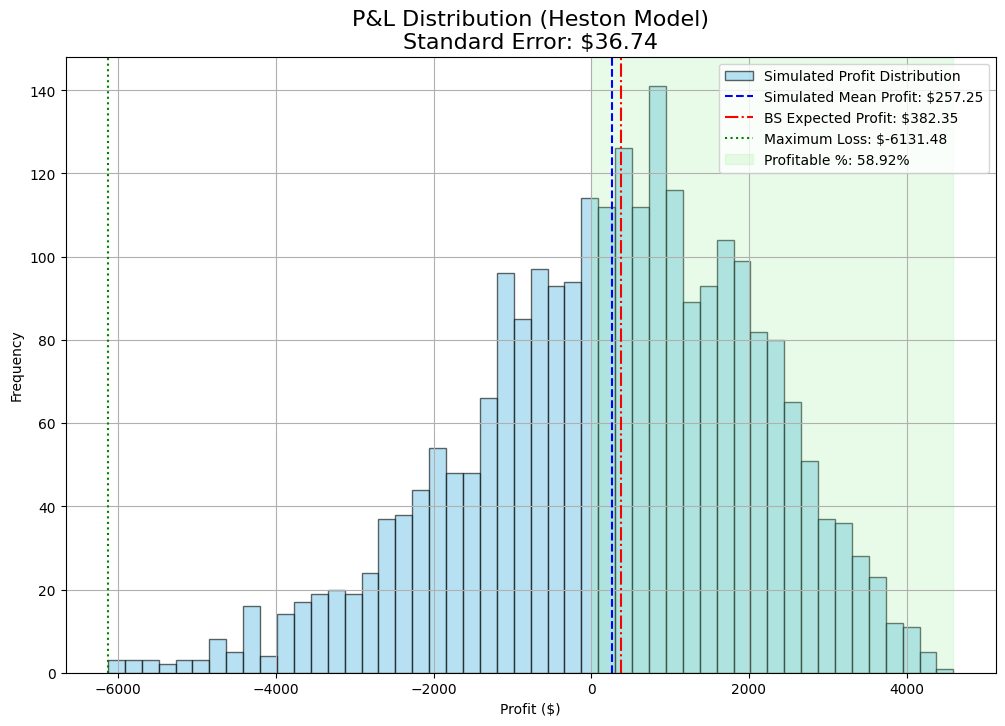

In [12]:
# Plot the Distribution 
plt.figure(figsize=(12, 8))
plt.hist(profits_hedged, bins=50, alpha=0.6, color='skyblue', edgecolor='black',label="Simulated Profit Distribution")
plt.axvline(sim_mean, color="blue", linestyle="--", label=f"Simulated Mean Profit: ${sim_mean:.2f}")

plt.axvline(bs_expected, color="red", linestyle="-.", label=f"BS Expected Profit: ${bs_expected:.2f}")

plt.axvline(max_loss, color="green", linestyle=":", label=f"Maximum Loss: ${max_loss:.2f}")
plt.axvspan(0, max(profits_hedged), color="lightgreen", alpha=0.2,
            label=f"Profitable %: {profit_percent:.2f}%")

plt.title(f"P&L Distribution (Heston Model)\nStandard Error: ${sim_se:.2f}", fontsize=16)
plt.xlabel("Profit ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

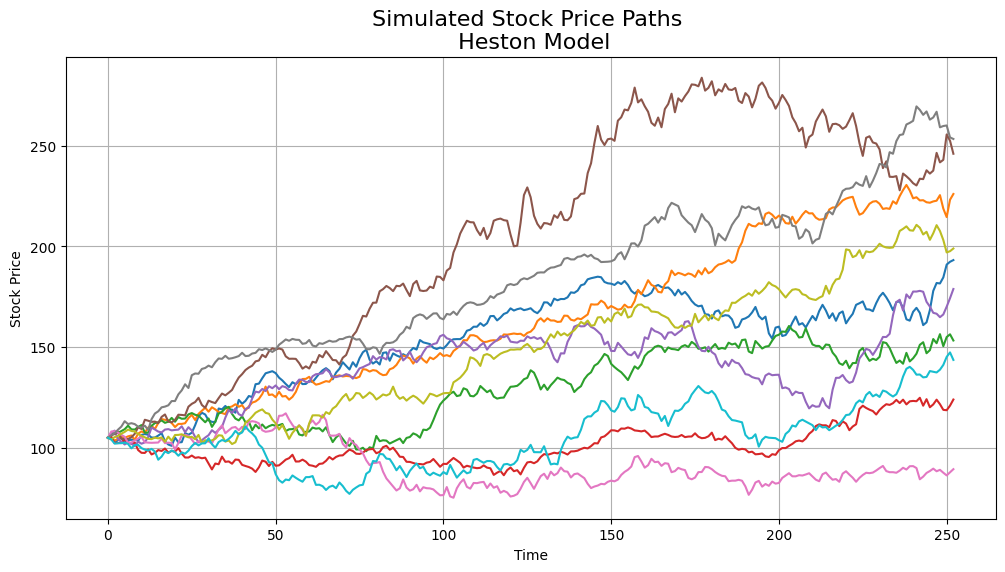

In [13]:
# Parameters
S0 = 105
v0 = 0.09
r = 0.035
t = 1
mu = 0.4
n_steps = 252
n_sims = 10  

# Heston parameters
kappa = 3.0
theta = 0.09
xi = 0.4
rho = -0.7

# Simulate paths
paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu, n_sims, return_vol=True)

# Plot the stock price paths
plt.figure(figsize=(12, 6))
for i in range(n_sims):
    plt.plot(paths[i], lw=1.5)
plt.title(f"Simulated Stock Price Paths \n Heston Model", fontsize=16)
plt.xlabel(f"Time")
plt.ylabel(f"Stock Price")
plt.grid(True)
plt.show()


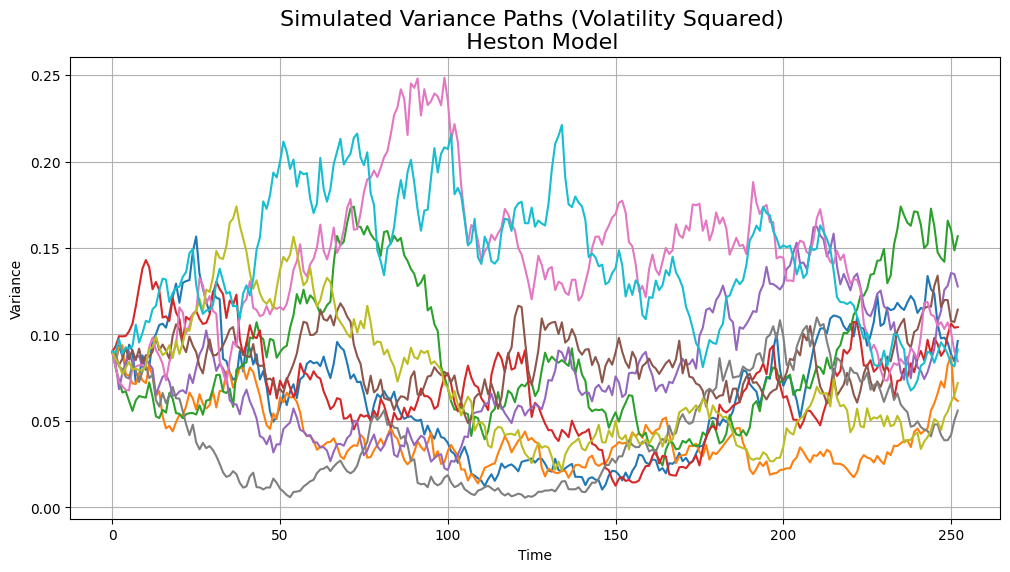

In [14]:
plt.figure(figsize=(12, 6))
for i in range(n_sims):
    plt.plot(vols[i], lw=1.5)
plt.title(f"Simulated Variance Paths (Volatility Squared) \n  Heston Model", fontsize=16)
plt.xlabel(f"Time")
plt.ylabel(f"Variance")
plt.grid(True)
plt.show()


In [15]:
# Parameters
S0 = 150
K = 100
v0 = 0.09             
r = 0.035
t = 1
mu = -0.4              
n_steps = 252
n_sims = 2500
num_options = 1000

# Heston model parameters
kappa = 3.0           # Mean reversion speed
theta = 0.09          # Long-run variance
xi = 0.4              # Volatility of volatility
rho = -0.7            # Correlation between asset and volatility

# Compute Premium and BS Price
avg_sigma = np.sqrt(theta)  # Average implied volatility assumption
premium = bs_call(S0, K, avg_sigma + 0.01, t, r)  # Overpriced sale
bs_price = bs_call(S0, K, avg_sigma, t, r)

# Simulate Call Option Replication Costs under Heston
hedged_values = heston_call_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu)

# Compute Profit (premium - hedging cost)
profits_hedged = num_options * (premium - hedged_values)

# Compute metrics
sim_mean = np.mean(profits_hedged)
sim_se = np.std(profits_hedged) / np.sqrt(n_sims)
bs_expected = num_options * (premium - bs_price)
max_loss = np.min(profits_hedged)
profit_percent = np.mean(profits_hedged >= 0) * 100




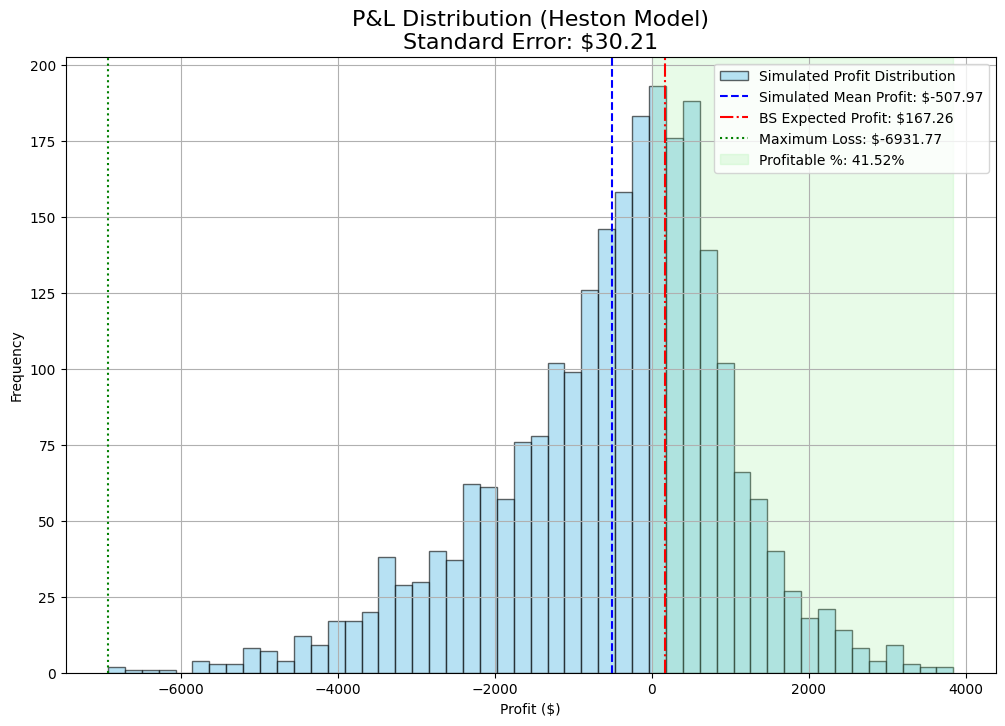

In [16]:
# Plot the Distribution 
plt.figure(figsize=(12, 8))
plt.hist(profits_hedged, bins=50, alpha=0.6, color='skyblue', edgecolor='black',label="Simulated Profit Distribution")
plt.axvline(sim_mean, color="blue", linestyle="--", label=f"Simulated Mean Profit: ${sim_mean:.2f}")

plt.axvline(bs_expected, color="red", linestyle="-.", label=f"BS Expected Profit: ${bs_expected:.2f}")

plt.axvline(max_loss, color="green", linestyle=":", label=f"Maximum Loss: ${max_loss:.2f}")
plt.axvspan(0, max(profits_hedged), color="lightgreen", alpha=0.2,
            label=f"Profitable %: {profit_percent:.2f}%")

plt.title(f"P&L Distribution (Heston Model)\nStandard Error: ${sim_se:.2f}", fontsize=16)
plt.xlabel("Profit ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

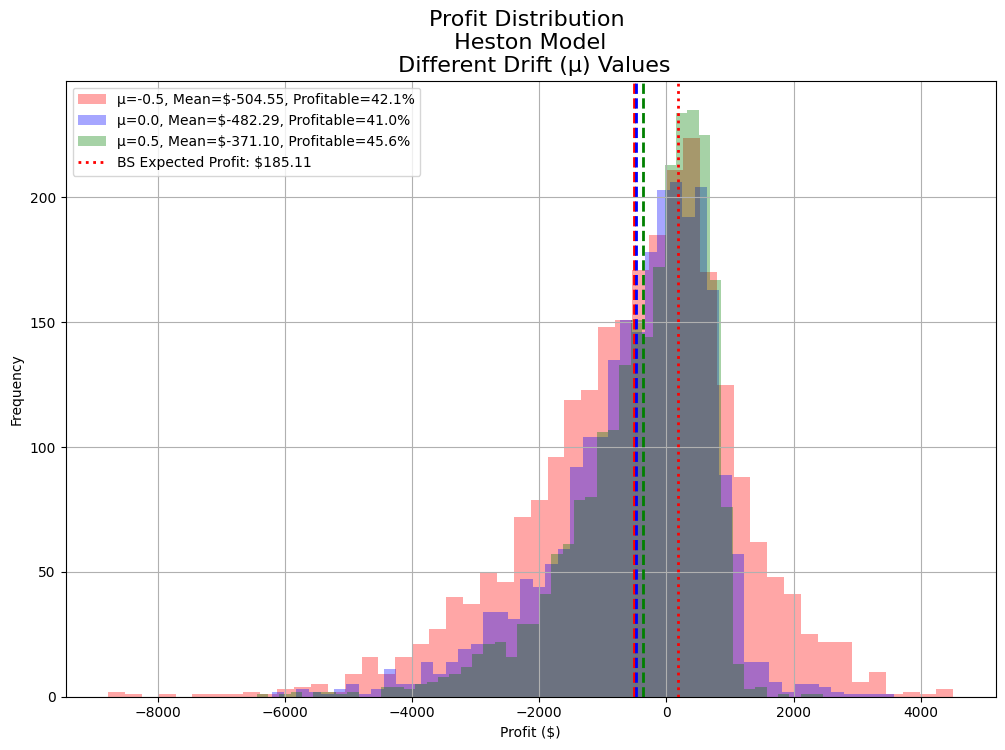

In [17]:
# List of drift values
mu_list = [-0.5, 0.0, 0.5]
colors = ['red', 'blue', 'green']

# Heston model & option parameters
S0 = 150
K = 100
v0 = 0.1
r = 0.035
t = 1
n_steps = 252
n_sims = 2500
num_options = 1000

# Heston parameters
kappa = 3.14
theta = 0.1
xi = 0.4
rho = -0.7

# Black-Scholes prices for reference (using avg sigma)
avg_sigma = np.sqrt(theta)
bs_price = bs_call(S0, K, avg_sigma, t, r)
premium = bs_call(S0, K, avg_sigma + 0.01, t, r)

# Start plotting
plt.figure(figsize=(12, 8))

for i, mu in enumerate(mu_list):
    # Simulate hedged payouts using Heston MC
    hedged_payouts = heston_call_MC(S0, K, v0, r, t, n_steps,
                                     kappa, theta, xi, rho,
                                     n_sims=n_sims, mu=mu)
    
    # Compute profit
    profits = num_options * (premium - hedged_payouts)

    # Plot histogram
    plt.hist(profits, bins=50, alpha=0.35, color=colors[i],
             label=f"μ={mu}, Mean=${np.mean(profits):.2f}, Profitable={np.mean(profits>=0)*100:.1f}%")
    
    # Add vertical mean line
    plt.axvline(np.mean(profits), color=colors[i], linestyle='--', linewidth=2)

# Add BS expected profit line
bs_expected = num_options * (premium - bs_price)
plt.axvline(bs_expected, color="red", linestyle=":", linewidth=2,
            label=f"BS Expected Profit: ${bs_expected:.2f}")

# Final plot formatting
plt.title(f"Profit Distribution \n Heston Model \n Different Drift (μ) Values", fontsize=16)
plt.xlabel("Profit ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


### Impact of Drift on Hedged Call Seller's Profit under the Heston model

The results show a clear relationship between the market drift and hedging outcomes. In particular, higher drift leads to lower average profits which in turn increases hedging costs. On the other hand, a negative drift of μ = -0.5 yielded the highest profit most likely profit. As drift increases, mean profit and profitability probability decrease, highlighting the increased risk faced by option sellers in bullish markets. The findings here are further evidence on the impact of market drift on hedging outcomes, and serve to emaphasize the results from class.


